## Описание проекта.

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

***Описание услуг.***

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).


Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).


За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

***Описание данных***

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.


Во всех файлах столбец `customerID` содержит код клиента.

***Информация о договорах актуальна на 1 февраля 2020.***

## Анализ имеющихся данных.

In [1]:
%%capture
# install phik (if not installed yet)
import sys
!"{sys.executable}" -m pip install phik
import lightgbm as lgb
import phik

In [2]:
#импортируем библиотеку
import pandas as pd
import re
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings



from phik.report import plot_correlation_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_validate, PredefinedSplit, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier


warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
# читаем датасеты и присваиваем соответствующим переменным
try:
    contract = pd.read_csv('/datasets/final_provider/contract.csv', index_col=0)
    internet = pd.read_csv('/datasets/final_provider/internet.csv', index_col=0)
    personal = pd.read_csv('/datasets/final_provider/personal.csv', index_col=0)
    phone = pd.read_csv('/datasets/final_provider/phone.csv', index_col=0)
    
except:
    contract = pd.read_csv(r'C:\Users\Asus\Desktop\final_provider\contract.csv', index_col=0)
    internet = pd.read_csv(r'C:\Users\Asus\Desktop\final_provider\internet.csv', index_col=0)
    personal = pd.read_csv(r'C:\Users\Asus\Desktop\final_provider\personal.csv', index_col=0)
    phone = pd.read_csv(r'C:\Users\Asus\Desktop\final_provider\phone.csv', index_col=0)

In [4]:
# Cоздание функции-шаблона для вывода  общей информации о датасете
def PRINT_SEPARATOR(): #разделитель
    print('_'*70)
    print()
    
    
def display_information(df):
    print('INFO')
    display(df.info())
    PRINT_SEPARATOR()
    print('HEAD ')
    display(df.head())
    PRINT_SEPARATOR()
    print('DESCRIBE')
    display(df.describe(include='all'))
    PRINT_SEPARATOR()
    print('MISSING VALUES')
    display(df.isnull().sum())
    # Проверка на дублирующиеся индексы,
    # (так как в целом признаки могут быть полностью идентичными у разных пользователей)
    PRINT_SEPARATOR()
     # т к во всех датасетах столбец с customerID представлен как столбец индекса, отдельно смотрим наличие повторений
    print('DUPLICATES (по индексу)')
    display(df.index[df.index.duplicated()].unique())

***_Далее проанализируем каждый датасет по отдельности с использованием функции-шаблона._***

### Информация о договоре

In [5]:
display_information(contract)

INFO
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


None

______________________________________________________________________

HEAD 


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


______________________________________________________________________

DESCRIBE


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043.000000,7043
unique,77,5,3,2,4,NaN,6531
top,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,20.2
freq,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


______________________________________________________________________

MISSING VALUES


BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

______________________________________________________________________

DUPLICATES (по индексу)


Index([], dtype='object', name='customerID')

***Итог:***
- в датасете 7 043 строки с данными по 7-мью признакам;
- Столбцы содержат данные о:
    - customer_id - ID пользователя;
    - begin_date - дата начала пользования услугами;
    - end_date - дата окончания использования услуг;
    - type - переодичность оплаты;
    - paperless_billing - безналичный расчет;
    - payment_method - способ оплаты ;
    - monthly_charges - размер ежемесячного платежа;
    - total_charges - сумма, списанная с пользователя за все время. 
- пропусков и дубликатов нет. В том числе, отсутствуют дублирующиеся ID клиентов;
- в качестве целевого признака логично принять информацию, ушел ли клиент на момент формирования датасета;
- _в рамках предобработки данных следует_:
    - привести названия столбцов к стандарту *snake_case*;
    - изменить тип данных в столбцах *BeginDate* и *EndDate* на *datetime*, в столбцах, содержащих категориальные данные - к *category*, *TotalCharges* -  к числовому типу, что соответствует содержащейся в них информации;
    - добавить категориальный столбец с информацией, ушел ли клиент на момент формирования датасета(целевой признак);
    - добавить столбец с информацией о длительности контракта, выяснить, целесообразно ли его добавление;
    - проанализировать полученные после изменений данные, в том числе, на дисбаланс классов;
    - проверить на наличие аномальных значений и выполнить их анализ и обработку.

### Персональные данные клиента.

In [6]:
display_information(personal)

INFO
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


None

______________________________________________________________________

HEAD 


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


______________________________________________________________________

DESCRIBE


,gender,SeniorCitizen,Partner,Dependents
count,7043,7043.000000,7043,7043
unique,2,NaN,2,2
top,Male,NaN,No,No
freq,3555,NaN,3641,4933
mean,NaN,0.162147,NaN,NaN
std,NaN,0.368612,NaN,NaN
min,NaN,0.000000,NaN,NaN
25%,NaN,0.000000,NaN,NaN
50%,NaN,0.000000,NaN,NaN
75%,NaN,0.000000,NaN,NaN


______________________________________________________________________

MISSING VALUES


gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

______________________________________________________________________

DUPLICATES (по индексу)


Index([], dtype='object', name='customerID')

***Итог:***
- в датасете 7 043 строки с данными по 4-м признакам;
- столбцы содержат данные о:
    - customer_id - ID пользователя;
    - gender - пол пользователя;
    - senior_citizen - наличие пенсионного статуса;
    - partner - состоит ли пользователь в отношениях;
    - dependents - наличие иждивенцев.
- пропусков и дубликатов нет. В том числе, отсутствуют дублирующиеся ID клиентов;
- признаки имеют категориальный характер;
- _в рамках предобработки данных следует_:
    - привести названия столбцов к стандарту *snake_case*;
    - изменить тип данных в столбцах, содержащих категориальные данные - к *category*, что соответствует содержащейся в них информации;
    - проанализировать полученные после изменений данные по каждому признаку;
    - проверить на наличие аномальных значений и выполнить их анализ и обработку.


### Информация об интернет-услугах.

In [7]:
display_information(internet)

INFO
<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


None

______________________________________________________________________

HEAD 


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


______________________________________________________________________

DESCRIBE


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785


______________________________________________________________________

MISSING VALUES


InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

______________________________________________________________________

DUPLICATES (по индексу)


Index([], dtype='object', name='customerID')

***Итог:***
- в датасете 5517 строки с данными по 8-м признакам;
- столбцы содержат данные о:
    - customer_id - ID пользователя;
    - internet_service - тип подключения (DSL или оптоволокно);
    - online_security - подключена ли услуга блокировки небезопасных сайтов;
    - online_backup - подключена ли облачное хранилище файлов для резервного копирования данных;
    - device_protection - подключен ли антивирус;
    - tech_support - подключена ли выделенная линия технической поддержки;
    - streaming_tv - подключено ли стриминговое телевидение;
    - streaming_movies - подключен ли каталог фильмов.
- пропусков и дубликатов нет. В том числе, отсутствуют дублирующиеся ID клиентов;
- признаки имеют категориальный характер;
- _в рамках предобработки данных следует_:
    - привести названия столбцов к стандарту *snake_case*;
    - изменить тип данных в столбцах, содержащих категориальные данные - к *category*, что соответствует содержащейся в них информации;
    - проанализировать полученные после изменений данные по каждому признаку;
    - проверить на наличие аномальных значений и выполнить их анализ и обработку.


### Информация об услугах телефонии.

In [8]:
display_information(phone)

INFO
<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


None

______________________________________________________________________

HEAD 


,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


______________________________________________________________________

DESCRIBE


,MultipleLines
count,6361
unique,2
top,No
freq,3390


______________________________________________________________________

MISSING VALUES


MultipleLines    0
dtype: int64

______________________________________________________________________

DUPLICATES (по индексу)


Index([], dtype='object', name='customerID')

***Итог:***
- в датасете 6361 строки с данными по 1-му признаку - наличие возможности ведения параллельных линий во время звонка;
- пропусков и дубликатов нет. В том числе, отсутствуют дублирующиеся ID клиентов;
- признак имеет категориальный характер;
- _в рамках предобработки данных следует_:
    - привести названия столбцов  стандарту *snake_case*;
    - изменить тип данных в столбце на *category*, что соответствует содержащейся информации;
    - проанализировать полученные после изменений данные.

### Общий вывод

- Явных пропусков и дубликатов в датасетах не выявлено;
- Данные требуют предобработки:
    - стандартизацию названий столбцов;
    - изменение типа данных в столбцах на соответствующие содержащейся информации;
    - объединение в общую таблицу по столбцу индекса, содержащего ID пользователя;
    - Размерность датасетов с информацией об интернет-услугах и услугах телефонии меньше, чем у датасетов с данными пользователей. А значит, потребуется предобработка сводной таблицы.
    - формирование дополнительных признаков: длительность пользования услугами и целевой признак - ушел ли абонент.

## План проекта.


1. **_Предобработка и подготовка данных_**:
    - привести названия столбцов  стандарту *snake_case*;
    - изменить тип данных в столбцах датафреймов соответственно содержащейся информации;
    - объединить все датасеты в общую таблицу, базируясь на столбце *customerID*;
    - так как количество строк в датасетах неодинаково, необходимо выполнить проверку получившейся таблицы на пропуски, дубликаты, не произошло ли потери данных;
    - на основании имеющейся информации сформировать столбцы с дополнительными признаками:
        - целевой признак - ушел ли пользователь на момент формирования датасета? (да/нет);
        - длительность пользования услугами компаннии на момент формирования датасета.
    - проанализировать полученные после изменений данные:
        - посмотреть на соотношение "категорий" в категориальных признаках, есть ли выбросы, аномальные значения;
        - есть ли корреляция между признаками, дисбаланс классов в целевом признаке;
        - что можно сказать о потоках клиентов за предоставленный период и чего можно ожидать?
        
        
2. **_Выбор дальнешей тактики:_** 
    - определить, требуются ли дополнительные действия с данными(кодирование, масштабирование);
    - формирование выборок;
    - выбор моделей.
    
    
3. **_Подбор гиперпараметров и обучение моделей_**


4. **_Сравнение эффективности и скорости моделей на тестовой выборке:_**
    - какие модели показывают лучший результат метрики AUC-ROC;
    - выбор оптимальной модели в соотношении результат/скорость.
    
    
5. **_Итоговый вывод._**





### Вопросы.


- Есть ли конкретные требования по скорости прогнозирования? Быстро или очень быстро и чуть менее точно? Будет ли использована модель "в реальном времени" и персонализировано по отношению к клиенту "в группе риска" или для формирования групп, попадающих под бонусы?(в принципе, по отношению к данному проекту такой вопрос бессмысленный, но при реальном кейсе стоял бы вопрос о предложении акций и бонусов, актуальных для конкретного пользователя, на основании его потребностей, или же формировании групп по признакам, определяющим будущие предложения)

- абоненты только физические лица или есть вероятность наличия юридических лиц? (в дальнейшем в столбце оюб общих расходах возможно наличие больших чисел. Насколько они могут соответствовать действительности и что с ними делать? ~~удалять, вероятно~~)
- есть ли скидка для абонентов, оплачивающих сразу большой промежуток времени? Как для них расчитывается помесячная оплата?(так же не думаю, что сильно существенно, но на практике было бы важно, вероятно)
- в каком количестве использовать визуализацию? По ключевым моментам или широко?

## Предобработка и подготовка данных

### Объединяем датасеты.

In [9]:
data = contract.merge(right=personal, on='customerID', validate='one_to_one')
#data.head()
data = data.merge(right=internet, how='left', on='customerID')
#data.head()
data = data.merge(right=phone, how='left', on='customerID')
data.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [10]:
data.shape

(7043, 19)

***Итог:*** при объединении данные не потеряны.

### Приведём названия столбцов стандарту snake_case.

In [11]:
_underscorer1 = re.compile(r'(.)([A-Z][a-z]+)')
_underscorer2 = re.compile('([a-z0-9])([A-Z])')

def to_snake_case(columns):    
    return list(map(lambda string: _underscorer2.sub(r'\1_\2', _underscorer1.sub(r'\1_\2', string)).lower(), columns))

data.columns = to_snake_case(data.columns)
data.columns

Index(['begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'gender', 'senior_citizen',
       'partner', 'dependents', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'multiple_lines'],
      dtype='object')

Цель достигнута.

### Изучим сводную таблицу признаков.

In [12]:
display_information(data)

INFO
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   begin_date         7043 non-null   object 
 1   end_date           7043 non-null   object 
 2   type               7043 non-null   object 
 3   paperless_billing  7043 non-null   object 
 4   payment_method     7043 non-null   object 
 5   monthly_charges    7043 non-null   float64
 6   total_charges      7043 non-null   object 
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   int64  
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  internet_service   5517 non-null   object 
 12  online_security    5517 non-null   object 
 13  online_backup      5517 non-null   object 
 14  device_protection  5517 non-null   object 
 15  tech_support       5517 non-null   object 
 16  streaming

None

______________________________________________________________________

HEAD 


,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


______________________________________________________________________

DESCRIBE


,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
count,7043,7043,7043,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,5517,5517,5517,5517,5517,5517,5517,6361
unique,77,5,3,2,4,NaN,6531,2,NaN,2,2,2,2,2,2,2,2,2,2
top,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,20.2,Male,NaN,No,No,Fiber optic,No,No,No,No,No,No,No
freq,366,5174,3875,4171,2365,NaN,11,3555,NaN,3641,4933,3096,3498,3088,3095,3473,2810,2785,3390
mean,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN,0.162147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN,0.368612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


______________________________________________________________________

MISSING VALUES


begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

______________________________________________________________________

DUPLICATES (по индексу)


Index([], dtype='object', name='customerID')

***Итого:*** Как и предполагалось, имеются пропуски в столбцах *internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies, multiple_lines*. Так же, необходимо изменить типы данных в столбцах.


Пропуски значений в столбцах с категориальными признаками возникли в строках абонентов, не подключенных к интернету совсем. По аналогии с имеющимися значениями, заменяем пропуски значением *"No"*:

In [13]:
str_cols = data.columns[data.dtypes=='object']
data[str_cols] = data[str_cols].fillna('No')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   begin_date         7043 non-null   object 
 1   end_date           7043 non-null   object 
 2   type               7043 non-null   object 
 3   paperless_billing  7043 non-null   object 
 4   payment_method     7043 non-null   object 
 5   monthly_charges    7043 non-null   float64
 6   total_charges      7043 non-null   object 
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   int64  
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  internet_service   7043 non-null   object 
 12  online_security    7043 non-null   object 
 13  online_backup      7043 non-null   object 
 14  device_protection  7043 non-null   object 
 15  tech_support       7043 non-null   object 
 16  streaming_tv  

### ***Изменим типы данных в столбцах на соответствующие содержащейся информации.***

In [14]:
data['type']=data['type'].astype('category')   
data['paperless_billing']=data['paperless_billing'].astype('category')      
data['payment_method']=data['payment_method'].astype('category')      
data['monthly_charges']=pd.to_numeric(data['monthly_charges'], errors='coerce')           
data['gender']=data['gender'].astype('category')               
data['senior_citizen']=data['senior_citizen'].astype('category')         
data['partner']=data['partner'].astype('category')          
data['dependents']=data['dependents'].astype('category')         
data['internet_service']=data['internet_service'].astype('category')


В столбцах с интернет-сервисами переводим значения к "True/False" :

In [15]:
data['online_security']=(data['online_security']== "Yes").astype('category')       
data['online_backup']=(data['online_backup']== "Yes").astype('category')        
data['device_protection']=(data['device_protection']== "Yes").astype('category')      
data['tech_support']=(data['tech_support']== "Yes").astype('category')     
data['streaming_tv']=(data['streaming_tv']== "Yes").astype('category')       
data['streaming_movies']=(data['streaming_movies']== "Yes").astype('category')      
data['multiple_lines']=(data['multiple_lines']== "Yes").astype('category')    

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   begin_date         7043 non-null   object  
 1   end_date           7043 non-null   object  
 2   type               7043 non-null   category
 3   paperless_billing  7043 non-null   category
 4   payment_method     7043 non-null   category
 5   monthly_charges    7043 non-null   float64 
 6   total_charges      7043 non-null   object  
 7   gender             7043 non-null   category
 8   senior_citizen     7043 non-null   category
 9   partner            7043 non-null   category
 10  dependents         7043 non-null   category
 11  internet_service   7043 non-null   category
 12  online_security    7043 non-null   category
 13  online_backup      7043 non-null   category
 14  device_protection  7043 non-null   category
 15  tech_support       7043 non-null   category
 

### Пропуски в "TotalCharges"

In [16]:
data['total_charges'].value_counts()

20.2       11
           11
19.75       9
20.05       8
19.9        8
           ..
2727.8      1
1677.85     1
2909.95     1
155.9       1
81.05       1
Name: total_charges, Length: 6531, dtype: int64

Видим, что среди значений имеется неявный пропуск. Посмотрим на строки, содержащие этот пропуск в поле *total_charges*

In [17]:
data[data['total_charges'] == ' ']

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,True,False,True,True,True,False,False
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,No,Yes,No,False,False,False,False,False,False,False
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,True,True,True,False,True,True,False
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,No,False,False,False,False,False,False,True
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,True,True,True,True,True,False,False
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,No,False,False,False,False,False,False,False
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,No,False,False,False,False,False,False,True
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,No,False,False,False,False,False,False,False
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,No,False,False,False,False,False,False,False


Видим, что все пропущенные значения приходятся на дату выгрузки датасета. Скорее всего, это новые пользователи и данные просто не успели заполнить. 

Признак *TotalCharges* преобразуем из строкового типа в "float", но сначала *" "* заменяем на "0".

In [18]:
data['total_charges'] = data['total_charges'].apply(lambda x: '0' if x == " " else x)

data['total_charges']=pd.to_numeric(data['total_charges'], errors='coerce') 

Проверяем:

In [19]:
data[data['begin_date'] == '2020-02-01']

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0.0,Female,0,Yes,Yes,DSL,True,False,True,True,True,False,False
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0.0,Male,0,No,Yes,No,False,False,False,False,False,False,False
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0.0,Female,0,Yes,Yes,DSL,True,True,True,False,True,True,False
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,0.0,Male,0,Yes,Yes,No,False,False,False,False,False,False,True
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,0.0,Female,0,Yes,Yes,DSL,True,True,True,True,True,False,False
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,0.0,Male,0,Yes,Yes,No,False,False,False,False,False,False,False
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,0.0,Male,0,Yes,Yes,No,False,False,False,False,False,False,True
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,0.0,Female,0,Yes,Yes,No,False,False,False,False,False,False,False
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,0.0,Male,0,Yes,Yes,No,False,False,False,False,False,False,False


### Обработка столбцов, содержащих даты.
***Особая работа нужна со столбцами, содержащими дату:***

Сформируем целевой признак - *ушел ли абонент на момент формирования датасета или нет?*

Т к действующий абонент имеет в столбце *end_date* отметку "No", на основании ее формируем столбец *contract_status*:

In [20]:
data['contract_status'] = data['end_date'].apply(lambda x: 1 if x == "No" else 0)

Далее заменяем  отметку "No" на дату формирования датасета:

In [21]:
data['end_date'] = data['end_date'].apply(lambda x: '2020-02-01' if x == "No" else x)

Преобразуем столбцы в тип *date_time* и добавляем столбец, содержащий данные о длительности контракта абонента на момент выгрузки данных:

In [22]:
data['end_date'] = pd.to_datetime(data['end_date'], format='%Y-%m-%d')
data['begin_date'] = pd.to_datetime(data["begin_date"], format='%Y-%m-%d')

data['contract_duration'] = (data['end_date'] - data['begin_date']).dt.days

Так как модель будет использоваться с данными за различные временные периоды, удаляем столбцы с датами:

In [23]:
data = data.drop(['begin_date', 'end_date'], axis=1)


In [24]:
data.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,contract_status,contract_duration
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,False,True,False,False,False,False,False,1,31
5575-GNVDE,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,True,False,True,False,False,False,False,1,1036
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,True,True,False,False,False,False,False,0,61
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,True,False,True,True,False,False,False,1,1371
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,False,False,False,False,False,False,False,0,61


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   type               7043 non-null   category
 1   paperless_billing  7043 non-null   category
 2   payment_method     7043 non-null   category
 3   monthly_charges    7043 non-null   float64 
 4   total_charges      7043 non-null   float64 
 5   gender             7043 non-null   category
 6   senior_citizen     7043 non-null   category
 7   partner            7043 non-null   category
 8   dependents         7043 non-null   category
 9   internet_service   7043 non-null   category
 10  online_security    7043 non-null   category
 11  online_backup      7043 non-null   category
 12  device_protection  7043 non-null   category
 13  tech_support       7043 non-null   category
 14  streaming_tv       7043 non-null   category
 15  streaming_movies   7043 non-null   category
 

### Вывод по предобработке данных.

- выболнено формирование датасета, включающего все признаки;
- потери данных не произошло;
- названия столбцов скорректированы;
- изменены типы данных в столбцах на соответсвующие;
- пропуски заполнены;
- сформирован целевой признак - статус абонента на момент формирования датасета;
- добавлен столбец с длительностью контрактов абонентов;
- удалены столбцы с датами, чтобы убрать "привязку" к определенному временному интервалу.

Очевидные манипуляции выполнены. Далее изучим признаки по отдельности и при необходимости выполним дополнительную обработку.

## Исследовательский анализ признаков.

Визуализируем соотношения "категорий" в категориальных признаках:

In [26]:
cat_features = ['gender', 'senior_citizen', 'partner', 'dependents', 'type', 'paperless_billing', 'payment_method',
                'internet_service', 'multiple_lines', 'contract_status']

cat_features2 = [ 'online_security', 'online_backup', 'device_protection', 'tech_support',
               'streaming_tv', 'streaming_movies']

def label_size(df, col):
    labels = list(df[col].unique())
    sizes = []
    for i in labels:
        sizes.append(df.loc[df[col] == i][col].count())
    return labels, sizes


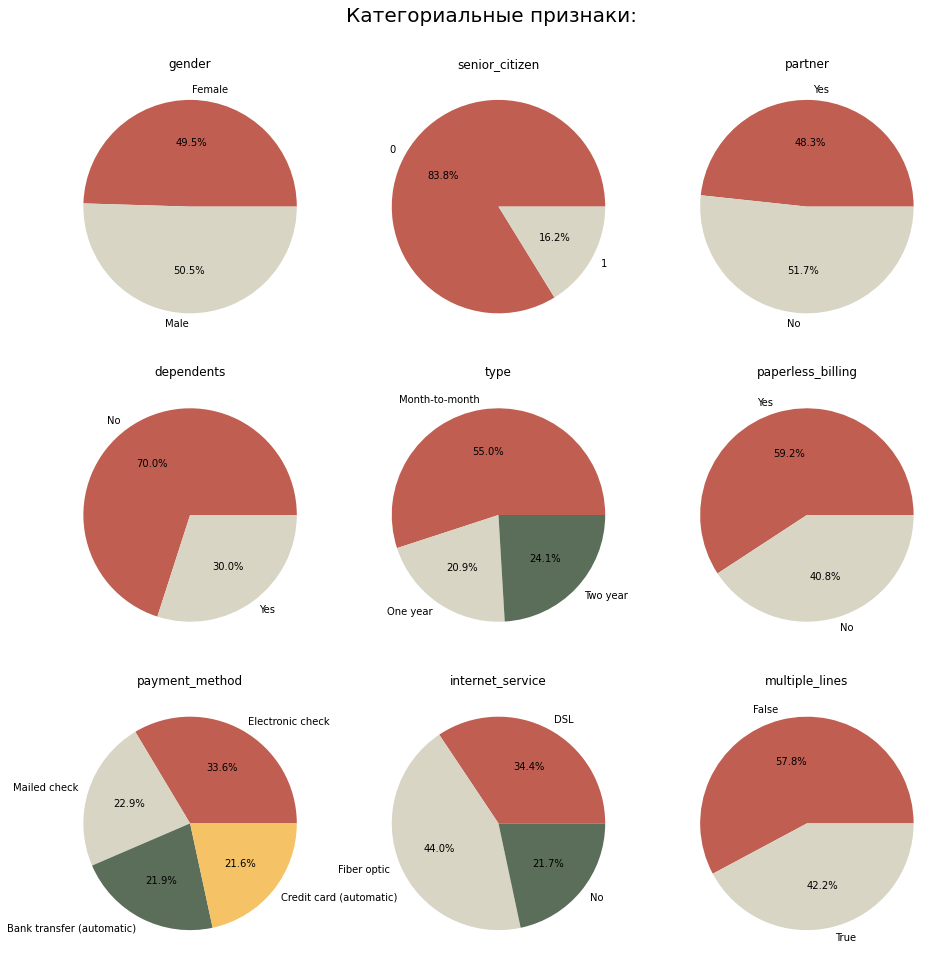

In [27]:
fig, axs = plt.subplots(3,3, figsize = (13,13))
plt.tight_layout( )
colors =[ '#C05E51','#D8D5C4','#5A6E5A','#F5C265'] #['#805C4D','#F4B46A','#9E8C8A','#EADDCD']
count = -1
for i in range(3):
    for x in range(3):
        count+=1
        col = cat_features[count]
        axs[i,x].pie(x=label_size(data, col)[1],
                     labels=label_size(data, col)[0], 
                     autopct='%1.1f%%', colors = colors)
        axs[i,x].title.set_text(str(col))

plt.suptitle('Категориальные признаки:', fontsize=20, y=1.05)
plt.show()

Признак| Вывод 
:----- | :---- 
'gender'| Соотношение полов примерно равно.
'senior_citizen'| Пенсионеры составляют только 16.2% от всех абонентов.
'partner'| Соотношение абонентов, состоящих в браке, и одиноких примерно равно.
'dependents'| Только у 30% абонентов есть дети или кто-то на попечении.
'type'| Относительное большинство абонентов предпочитают помесячную оплату, на год и на два вперед оплачивают примерно равное количество абонентов.
'paperless_billing'| Большинство абонентов предпочитают полчать электронные чеки.
'payment_method'| Раскрывает предыдущий пункт, детализируя информацию об оплате.
'internet_service'| На основании данного столбца можно разделить пользователей на тех, кто пользуется только телефоном, и тех, кто использует и интернет. Использующих интернет больше. Оптоволокно более популярно DHL-соединения.
'multiple_lines'| Услугой пользуются 42.2% пользователей.


### Размер ежемесячного платежа и суммарно затраченные абонентами суммы.

В предоставленном датасете значения помесяной оплаты заполнены даже у пользователей, оплативших год или два вперед. Принимаем их как вычисленные автоматически.

In [28]:
data['monthly_charges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64

<AxesSubplot:>

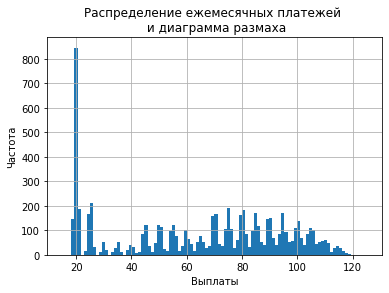

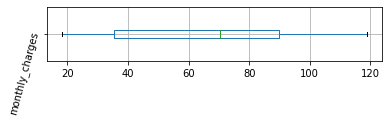

In [29]:
display(data['monthly_charges'].hist(bins=100, range=(15, 125)))
plt.title('Распределение ежемесячных платежей \n и диаграмма размаха')
plt.xlabel('Выплаты')
plt.ylabel('Частота')
plt.show()
plt.figure(figsize=(6, 1))
data.boxplot('monthly_charges', vert=False, rot=75)
plt.show()

Построим гистограмму распределения ежемесячных платежей в зависимости от статуса клиента.

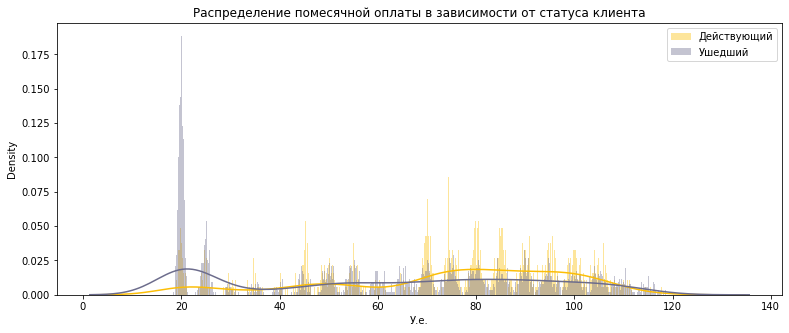

In [30]:
plt.figure(figsize=(13, 5))
sns.distplot(data[data['contract_status']==0]['monthly_charges'], label='Действующий', bins=1000, color='#FCBE07')
sns.distplot(data[data['contract_status']==1]['monthly_charges'], label='Ушедший', bins=1000, color='#6C6C8C')
plt.legend()
plt.title('Распределение помесячной оплаты в зависимости от статуса клиента')
plt.xlabel('У.е.');

**Видим,** что нет выбросов, а так же то, что ежемесячные платежи распределены неравномерно, т е не имеют "популярных" фиксированных сумм, есть только наиболе частая сумма в районе 20 и ряд более мелких "пиков". Вероятно, это можно связать с особенностями тарифов. Так же видим, что среди клиентов с прерваным контрактом наиболее распространены небольшие помесячные платежи. Это может быть связано с особенностями тарифа, либо нерегулярностью использования, либо с быстрым уходом клиента.

Нулевые значения в *total_charges* мы обработали выше. Вероятно, это новые пользователи, итоговую сумму оплаты которых на момент выгрузки данных еще не сформировали в системе.

Построим диаграмму размаха и гистограмму распределения суммарно затраченных абонентами сумм, исключив нулевые значения.

In [31]:
data_notnull= data[data['total_charges'] !=0]
data_notnull['total_charges'].describe()

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: total_charges, dtype: float64

<AxesSubplot:>

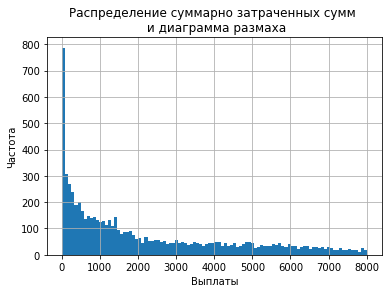

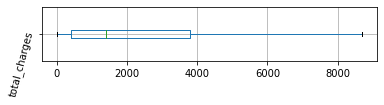

In [32]:
display(data_notnull['total_charges'].hist(bins=100,  range=(15, 8000)))
plt.title('Распределение суммарно затраченных сумм \n и диаграмма размаха')
plt.xlabel('Выплаты')
plt.ylabel('Частота')
plt.show()
plt.figure(figsize=(6, 1))
data_notnull.boxplot('total_charges', vert=False, rot=75)
plt.show()

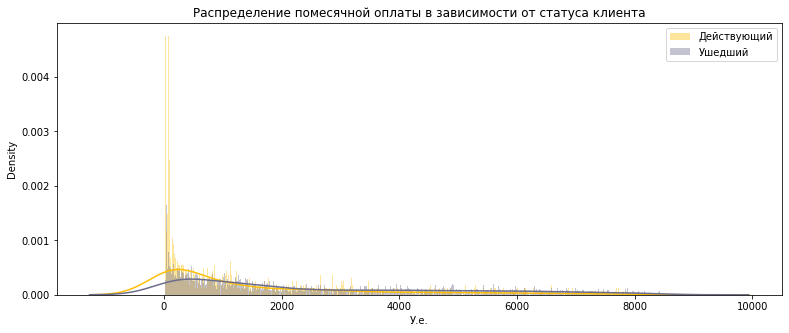

In [33]:
plt.figure(figsize=(13, 5))
sns.distplot(data[data['contract_status']==0]['total_charges'], label='Действующий', bins=1000, color='#FCBE07')
sns.distplot(data[data['contract_status']==1]['total_charges'], label='Ушедший', bins=1000, color='#6C6C8C')
plt.legend()
plt.title('Распределение помесячной оплаты в зависимости от статуса клиента')
plt.xlabel('У.е.');

Видим, что аномальных значений нет, хоть и есть достаточно большие суммы. Пик наблюдается в районе минимальных значений и, в целом, первые квартили наиболее часто встречаемы.

Среди ушедших абонентов все так же преобладают низкие суммы.


**Построим матрицу корреляции для количественных признаков:**

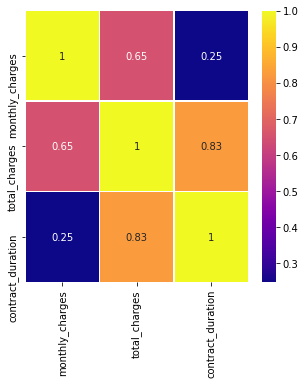

In [34]:
num_features_data = data[['monthly_charges', 'total_charges', 'contract_duration']]
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(num_features_data.corr(),cmap='plasma',annot=True, linewidths=.5)
plt.show()

Видим, что  *'total_charges'* и  *'contract_duration'* сильно коррелируют между собой, как и *'monthly_charges'* и *'total_charges'*. Что ожидаемо, но в дальнейшем лучше обратить внимание.

### Интернет и телефония.

Чтобы рассмотреть признаки, связанные с использованием абонентом интернета, сформируем отдельные выборки:

In [35]:
#только телефон
phone_only = data[data['internet_service'] == 'No']
phone_only.describe() 

,monthly_charges,total_charges,contract_status,contract_duration
count,1526.000000,1526.000000,1526.000000,1526.000000
mean,21.079194,662.604784,0.925950,930.632372
std,2.164221,555.627705,0.261938,741.387814
min,18.250000,0.000000,0.000000,0.000000
25%,19.700000,157.825000,1.000000,245.000000
50%,20.150000,519.200000,1.000000,761.000000
75%,20.900000,1108.650000,1.000000,1606.500000
max,26.900000,2006.950000,1.000000,2191.000000


In [36]:
#телефон и интернет
internet_user = data[data['internet_service'] != 'No']
internet_user.describe()

,monthly_charges,total_charges,contract_status,contract_duration
count,5517.000000,5517.000000,5517.000000,5517.000000
mean,76.844254,2727.031684,0.681711,1001.309770
std,21.924661,2356.045477,0.465855,748.637867
min,23.450000,0.000000,0.000000,0.000000
25%,59.950000,583.000000,0.000000,276.000000
50%,79.450000,2135.500000,1.000000,914.000000
75%,94.450000,4527.450000,1.000000,1706.000000
max,118.750000,8684.800000,1.000000,2191.000000


**Видно, что интернет и связанные с ним сервисы обходятся пользователям значительно дороже исключительно телефонной связи.**

Добавляем в основную таблицу столбец с информацией, подключен ли абонент к интернету. Проверяем через количество отрицательных значений:

In [37]:
data['internet_user'] = data['internet_service'].apply(lambda x: 1 if x != "No" else 0)
len(data[data['internet_user'] == 0])

1526

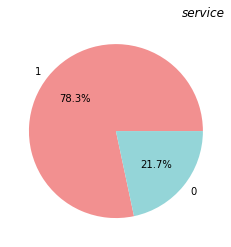

In [38]:
int_users = data['internet_user'].value_counts()

fig = plt.figure(figsize =(6, 4))
colors = [ '#F29090','#94D5D8'] # '#89a1d5', '#9dafd5']
plt.pie(int_users, labels = int_users.index,  colors = colors, autopct='%1.1f%%')
plt.title('service', loc="right", pad=None,
          fontstyle='italic') 
plt.show()

Построим гистограммы, визуализирующие соотношения по признакам в группах интернет-пользователей и использующих только телефон, а так же, часть графиков будет отражать соотношения внутри группы с подключенным интернетом.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


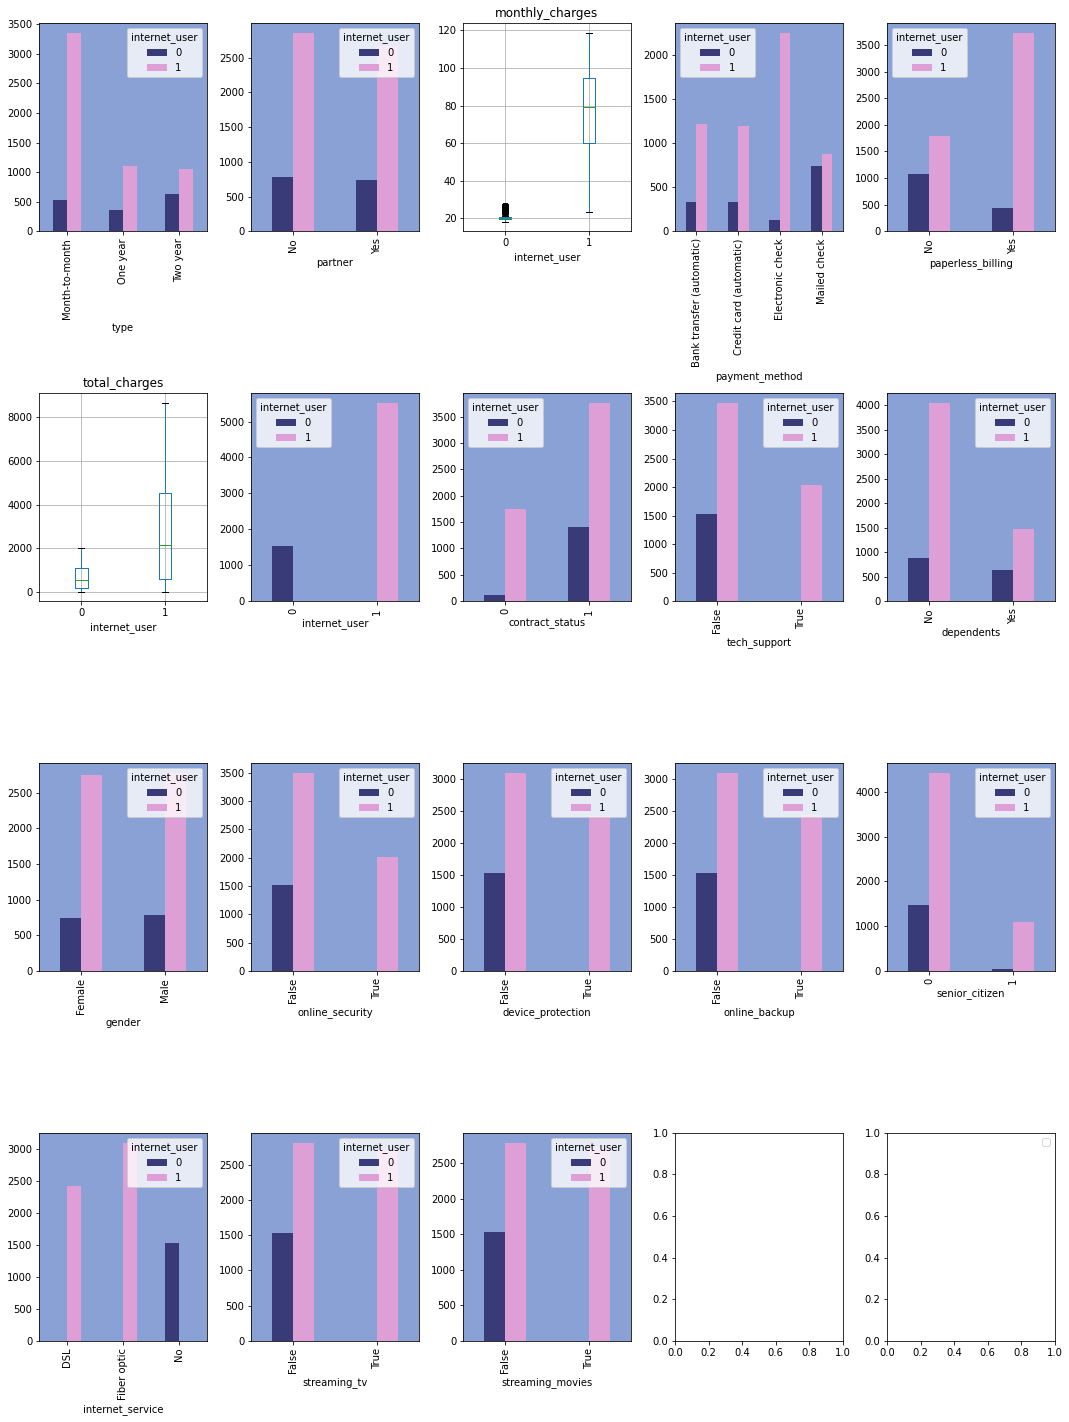

In [39]:
%matplotlib inline
fig, axs = plt.subplots(4, len(data.columns) // 4, figsize=(15,20))
axs = axs.flatten()

cols=list(set(data.columns) - set(['customerID'])-set(['contract_duration'])-set(['multiple_lines']))
for col, ax in zip(cols, axs):
    if data[col].dtype=='float64':
        data.boxplot(column=col, by='internet_user', ax=ax)
        plt.suptitle('')
    else:
        df = data.groupby([col, 'internet_user'])['internet_user'].count().unstack()
        df.plot(kind='bar', stacked=False, label='#internet_user (neg, pos)', ax=ax,  cmap='tab20b')
        plt.legend(loc='upper left')
        ax.set_facecolor('#89a1d5')
    
plt.tight_layout()
plt.legend()
plt.show() 

Признак| Вывод 
:----- | :---- 
'dependents'| соотношение "имеет иждевенца/не имеет" в группе интернет-пользователей более выражено,  в группе без интернета разница менее выражена
'senior_citizen'| среди пенсионеров значительно больше тех, кто использует только телефон
'paperless_billing'| большинство интернет-пользователей предпочитают безналичный расчет
'partner'| соотношение холостых и состоящих в браке в обеих группах примерно равно
'streaming_movies'| стриминговыми киносервисами пользуется примерно половина интернет-абонентов
'internet_service'| наиболее популярным средством подключения является оптоволокно
'online_security'| около трети интернет-абонентов используют  блокировку небезопасных сайтов
'type'| соотношение по типу оплаты интернет абонетов  примерно соответствует общей выборке, однако среди тех, кто использует только телефон, гораздо больший процент предпочитает оплату на год и два года вперед
'tech_support'| большинство интернет-пользователей обходятся без подключенной технической поддержки
'online_backup'| облачное хранилище подключено у меньшего количества интернет-абонентов 
'device_protection'| антивирус не подключен у меньшего количества пользователей
'gender'| соотношение полов примерно равно в обеих группах
'contract_status'| в группе пользователей интернета  ушедших клиентов относительно оставшихся, гораздо больше
'streaming_tv'|  стриминговыми тв-сервисами пользуются примерно равное количество клиентов
'payment_method'| по типу оплаты пользователи телефонии более консервативны 








***Вывод:*** по итогу, получаем два портрета пользователей: 
- многочисленные пользователи интернета, не пенсионеры, более мобильные и не заглядывающие далеко в будущее. Готовы дополнительно оплачивать как сам интернет, так и различные сервисы;
- и меньшее количество абонентов,использующих только телефонию. Преимущественно пенсионеры, но более "надежные" клиенты, чаще оплачивают на год-два вперед. Оплата только телефонии дешевле, это может являться дополнительным фактором. 


Вероятно, для удержания клиентов стоит обратить внимание на условия интернет-подключения. С учетом большего оттока в этой группе, вероятно, есть некоторые "проблемные" моменты для абонентов.

### Статус контракта

Определим как целевой признак.

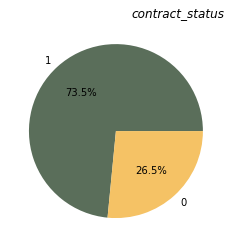

In [40]:
int_users = data['contract_status'].value_counts()
fig = plt.figure(figsize =(6, 4))
colors = [ '#5A6E5A','#F5C265','#94D5D8'] # '#89a1d5', '#9dafd5']
plt.pie(int_users, labels = int_users.index,  colors = colors, autopct='%1.1f%%')
plt.title('contract_status', loc="right", pad=None,
          fontstyle='italic') 
plt.show()

В датасете абоненты, прервавшие контракт, представлены 26.5%.

Визуализируем соотношения признаков в группе действующего контракта и ушедших.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


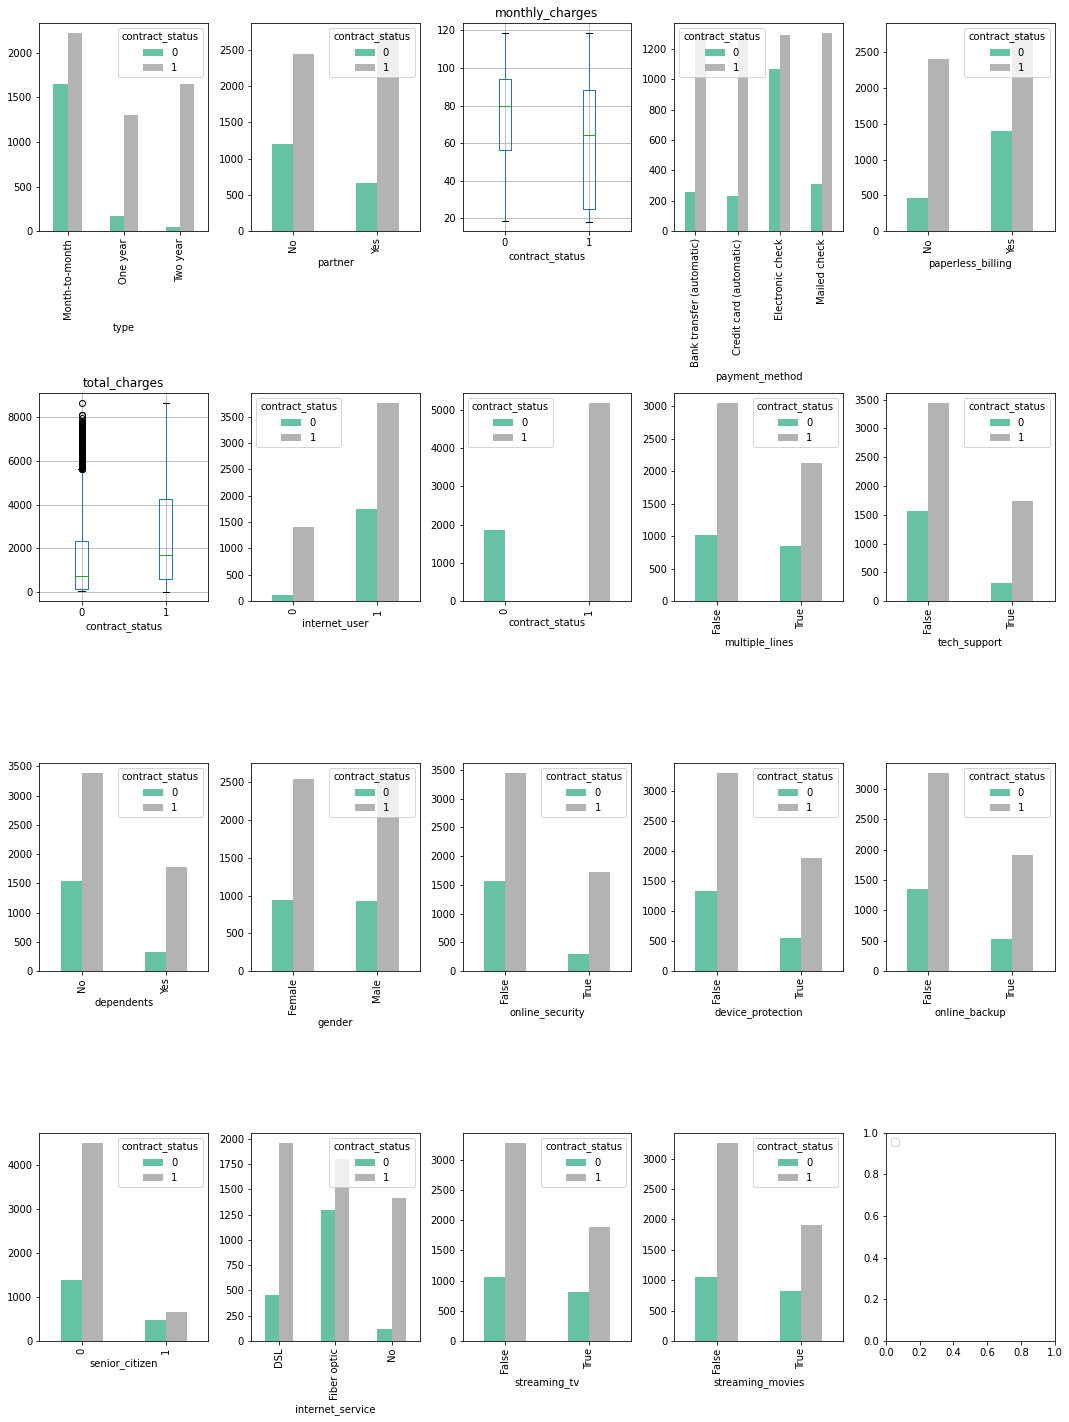

In [41]:
%matplotlib inline
fig, axs = plt.subplots(4, len(data.columns) // 4, figsize=(15,20))
axs = axs.flatten()
cols=list(set(data.columns) - set(['customerID'])-set(['contract_duration']))
for col, ax in zip(cols, axs):
    if data[col].dtype=='float64':
        data.boxplot(column=col, by='contract_status', ax=ax)
        plt.suptitle('')
    else:
        df = data.groupby([col, 'contract_status'])['contract_status'].count().unstack()
        df.plot(kind='bar', stacked=False, label='#contract_status (neg, pos)', ax=ax, cmap='Set2')
        plt.legend(loc='upper left')
    
plt.tight_layout()
plt.show() 

Признак| Вывод 
:----- | :---- 
'dependents'| у большинства ушедших абонентов не было иждивенцев
'senior_citizen'| среди ушедших было больше не-пенсионеров
'paperless_billing'| большинство ушедшихпользователей предпочитают безналичный расчет
'partner'| среди ушедших больше не состоящих в браке
'streaming_movies'| большинство(хоть и с небольшой разницей) из ушедших не пользовались стриминговыми киносервисами 
'internet_service'| наиболее популярным средством подключения у ушедших пользователей является оптоволокно
'online_security'| большинство ушедших не использовало  блокировку небезопасных сайтов
'type'| ушедшие абоненты преимущественно оплачивали помесячно
'tech_support'| большинство ушедших не было подключено к сервису технической поддержки
'online_backup'| облачное хранилище так же использовалось реже 
'device_protection'| антивирус не подключен у большего количества ушедших пользователей
'gender'| соотношение полов примерно равно в обеих группах
'payment_method'| по типу оплаты ушедшие пользователи  пользовались электронной оплатой
'internet_user' |большинство ушедших пользовалось интернетом


Таким образом, выходит, что ушедшие пользователи чаще всего платили ежемесячно,  в основном, не пользовались дополнительными сервисами, хотя и подключали интернет в большинстве своем. Так же, можно сказать, что ежемесячный платеж у них был выше, чем у действующих абонентов, однако в сумме платежей выходит немного. Вероятно, услугами связи польовались нерегулярно или же быстро прекращали контракт после заключения.




### Корреляция

#### Корреляция Пирсона

In [42]:
data.corr()

,monthly_charges,total_charges,contract_status,contract_duration,internet_user
monthly_charges,1.000000,0.651174,-0.193356,0.247754,0.763557
total_charges,0.651174,1.000000,0.198324,0.826109,0.375223
contract_status,-0.193356,0.198324,1.000000,0.352673,-0.227890
contract_duration,0.247754,0.826109,0.352673,1.000000,0.038951
internet_user,0.763557,0.375223,-0.227890,0.038951,1.000000


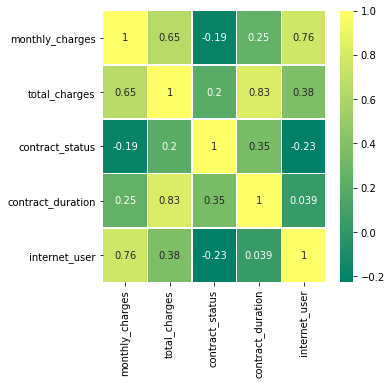

In [43]:

fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(data.corr(),cmap='summer',annot=True, linewidths=.5)
plt.show()

Корреляция Пирсона между признаками (Линейная зависимость признаков в датасете):

- корреляция Пирсона больше 0.82 между 'total_charges' и 'contract_duration'
- сильная связь есть между 'monthly_charges'и 'total_charges', корреляция Пирсона 0.65

### Корреляция Phi_K

Добавила этот метод, как более "чувствительный" к неленейным связям.

In [44]:
phik_overview = data.phik_matrix()

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'contract_status', 'contract_duration', 'internet_user']


In [45]:
phik_overview['contract_status'].sort_values(ascending=False)

contract_status      1.000000
contract_duration    0.474001
payment_method       0.449125
monthly_charges      0.360050
internet_user        0.349367
paperless_billing    0.295754
total_charges        0.278498
online_security      0.264580
tech_support         0.254615
dependents           0.253936
type                 0.251639
senior_citizen       0.233432
partner              0.232930
internet_service     0.196202
online_backup        0.126973
device_protection    0.101516
streaming_tv         0.096865
streaming_movies     0.093923
multiple_lines       0.059581
gender               0.000000
Name: contract_status, dtype: float64

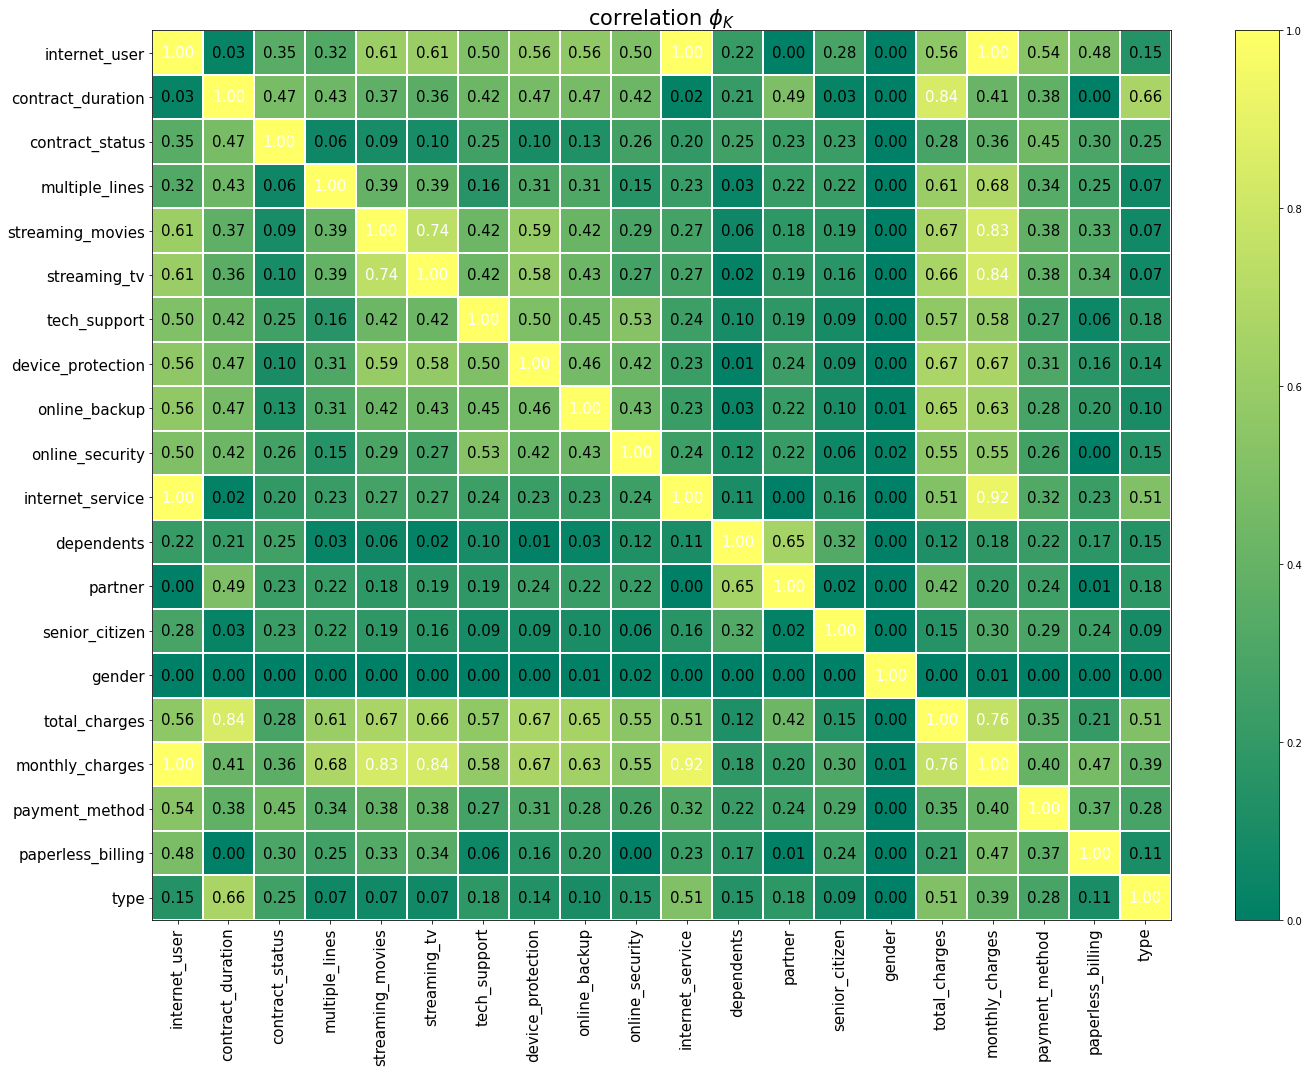

In [46]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="summer", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 15))
plt.tight_layout()

**Вывод:** 
- Со статусом контракта абонента коррелируют:
    - длительность договора
    - способ оплаты способ получения счета
    - ежемесячная оплата и общая сумма оплаты(которые коррелируют между собой)


- Общая выплаченая сумма коррелирует с подключенными сервисами. Что, вероятно, связано с их стоимостью.
- Так же, видно, что сервисы коррелируют друг с другом. Это может быть связано с тарифами, либо с готовностью пользователя оплачивать эти сервисы.
- наличие партнера коррелирует с наличием иждивенцев, что логично.

### Итоговый вывод по исследовательскому анализу.

1. Был выполнен анализ  общих для всех абонентов категориальных признаков:
Признак| Вывод 
:----- | :---- 
'senior_citizen'| Пенсионеры составляют только 16.2% от всех абонентов.
'dependents'| Только у 30% абонентов есть дети или кто-то на попечении.
'type'| Относительное большинство абонентов предпочитают помесячную оплату, на год и на два вперед оплачивают примерно равное количество абонентов.
'paperless_billing'| Большинство абонентов предпочитают полчать электронные чеки.
'internet_service'| На основании данного столбца можно разделить пользователей на тех, кто пользуется только телефоном, и тех, кто использует и интернет. Использующих интернет больше. Оптоволокно более популярно DHL-соединения.
'multiple_lines'| Услугой пользуются 42.2% пользователей.



2.  Так же, были составлены "портреты" абонентов,  пользующихся только телефонной связью, и подключенных к интернету и сопутствующим сервисам:
    - многочисленные пользователи интернета, не пенсионеры, более мобильные и не заглядывающие далеко в будущее. Готовы дополнительно оплачивать как сам интернет, так и различные сервисы;
    - и меньшее количество абонентов,использующих только телефонию. Преимущественно пенсионеры, но более "надежные" клиенты, чаще оплачивают на год-два вперед. Оплата только телефонии дешевле, это может являться дополнительным фактором. 
    - Вероятно, для удержания клиентов стоит обратить внимание на условия интернет-подключения. С учетом большего оттока в этой группе, вероятно, есть некоторые "проблемные" моменты для абонентов.


3. "Порции" ежемесячных платежей распределены неравномерно, т е не имеют "популярных" фиксированных сумм, есть только наиболе частая сумма в районе 20 и ряд более мелких "пиков". Вероятно, это можно связать с особенностями тарифов. Так же видим, что среди клиентов с прерваным контрактом наиболее распространены небольшие помесячные платежи. Это может быть связано с особенностями тарифа, либо нерегулярностью использования, либо с быстрым уходом клиента.


4. Так же, выявлено, что ушедшие пользователи чаще всего платили ежемесячно,  в основном, не пользовались дополнительными сервисами, хотя и подключали интернет в большинстве своем. Так же, можно сказать, что ежемесячный платеж у них был выше, чем у действующих абонентов, однако в сумме платежей выходит немного. Вероятно, услугами связи польовались нерегулярно или же быстро прекращали контракт после заключения.

5. Корреляция Пирсона между признаками:
    - корреляция Пирсона больше 0.82 между *'total_charges'* и *'contract_duration'*
    - сильная связь есть между *'monthly_charges'* и *'total_charges'*, корреляция Пирсона 0.65

6. Корреляция Phi_K:
    - Со статусом контракта абонента коррелируют:
        - длительность договора
        - способ оплаты способ получения счета
        - ежемесячная оплата и общая сумма оплаты(которые коррелируют между собой)
    - Общая выплаченая сумма коррелирует с подключенными сервисами. Что, вероятно, связано с их стоимостью.
    - Так же, видно, что сервисы коррелируют друг с другом. Это может быть связано с тарифами, либо с готовностью пользователя оплачивать эти сервисы.
    - наличие партнера коррелирует с наличием иждивенцев, что логично.



## Построение моделей

Методом *get_dummies* закодируем категориальные переменные:

In [47]:
datafirst = data.copy(deep=True)
data = pd.get_dummies(data, drop_first=True)

Проверим полученный датасет:

In [48]:
display_information(data)

INFO
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 24 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   monthly_charges                         7043 non-null   float64
 1   total_charges                           7043 non-null   float64
 2   contract_status                         7043 non-null   int64  
 3   contract_duration                       7043 non-null   int64  
 4   internet_user                           7043 non-null   int64  
 5   type_One year                           7043 non-null   uint8  
 6   type_Two year                           7043 non-null   uint8  
 7   paperless_billing_Yes                   7043 non-null   uint8  
 8   payment_method_Credit card (automatic)  7043 non-null   uint8  
 9   payment_method_Electronic check         7043 non-null   uint8  
 10  payment_method_Mailed check             7043 

None

______________________________________________________________________

HEAD 


,monthly_charges,total_charges,contract_status,contract_duration,internet_user,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,...,dependents_Yes,internet_service_Fiber optic,internet_service_No,online_security_True,online_backup_True,device_protection_True,tech_support_True,streaming_tv_True,streaming_movies_True,multiple_lines_True
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,29.85,29.85,1,31,1,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
5575-GNVDE,56.95,1889.50,1,1036,1,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3668-QPYBK,53.85,108.15,0,61,1,0,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0
7795-CFOCW,42.30,1840.75,1,1371,1,1,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0
9237-HQITU,70.70,151.65,0,61,1,0,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0


______________________________________________________________________

DESCRIBE


,monthly_charges,total_charges,contract_status,contract_duration,internet_user,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,...,dependents_Yes,internet_service_Fiber optic,internet_service_No,online_security_True,online_backup_True,device_protection_True,tech_support_True,streaming_tv_True,streaming_movies_True,multiple_lines_True
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,...,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.734304,0.734630,985.996166,0.783331,0.209144,0.240664,0.592219,0.216101,0.335794,...,0.299588,0.439585,0.216669,0.286668,0.344881,0.343888,0.290217,0.384353,0.387903,0.421837
std,30.090047,2266.794470,0.441561,747.587844,0.412004,0.406726,0.427517,0.491457,0.411613,0.472301,...,0.458110,0.496372,0.412004,0.452237,0.475363,0.475038,0.453895,0.486477,0.487307,0.493888
min,18.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.500000,398.550000,0.000000,273.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,70.350000,1394.550000,1.000000,883.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,89.850000,3786.600000,1.000000,1676.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,118.750000,8684.800000,1.000000,2191.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


______________________________________________________________________

MISSING VALUES


monthly_charges                           0
total_charges                             0
contract_status                           0
contract_duration                         0
internet_user                             0
type_One year                             0
type_Two year                             0
paperless_billing_Yes                     0
payment_method_Credit card (automatic)    0
payment_method_Electronic check           0
payment_method_Mailed check               0
gender_Male                               0
senior_citizen_1                          0
partner_Yes                               0
dependents_Yes                            0
internet_service_Fiber optic              0
internet_service_No                       0
online_security_True                      0
online_backup_True                        0
device_protection_True                    0
tech_support_True                         0
streaming_tv_True                         0
streaming_movies_True           

______________________________________________________________________

DUPLICATES (по индексу)


Index([], dtype='object', name='customerID')

Данные не потеряны, пропусков не обнаружено. Выполнено шифрование категориальных признаков.

### Сформируем выборки

Создадим переменную с *random_state*, которую будем использовать.

Разделим датасет на тренировочную, валидационную и тестовую выборки в соотношении  3:1:1.

In [49]:
random_st = 80822

In [50]:
data_test, data_train_valid = train_test_split(data, test_size=0.8, random_state=random_st)
data_train, data_valid = train_test_split(data_train_valid, test_size=0.25, random_state=random_st)

Выделим целевой признак и фичи.
Решено было избавиться от столбца *'total_charges'*, содержащего сумму всех платежей пользователя, т к получен высокий процент корреляции и, с учетом характера исследования, от него можно избавиться, оставив  высоко коррелирующий с общей суммой ежемесячный платеж, а так же удалить ID клиентов из индекса и вспомогательный столбец с данными об интернет-подключении пользователя.

In [51]:
features_test = data_test.drop(['contract_status',  'total_charges', 'internet_user'  ], axis=1).reset_index(drop=True)
target_test = data_test['contract_status']
features_train = data_train.drop(['contract_status',  'total_charges', 'internet_user' ], axis=1).reset_index(drop=True)
target_train = data_train['contract_status']
features_valid = data_valid.drop(['contract_status',  'total_charges', 'internet_user' ], axis=1).reset_index(drop=True)
target_valid = data_valid['contract_status']

In [52]:
print("Обучающая выборка:", data_train.shape)
print("Валидационная выборка:", data_valid.shape)
print("Тестовая выборка:", data_test.shape)

Обучающая выборка: (4226, 24)
Валидационная выборка: (1409, 24)
Тестовая выборка: (1408, 24)


### Дисбалланс классов

,quantity,%
contract_status,,
0,1869,26.536987
1,5174,73.463013


<AxesSubplot:>

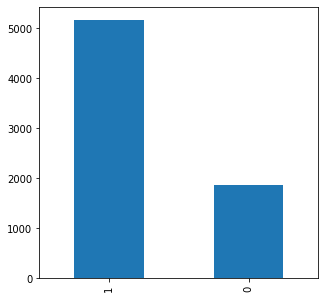

In [53]:
imbalance = data.groupby('contract_status').agg({'contract_status':'count'})
imbalance.rename(columns=lambda x: x.replace('contract_status', 'quantity'), inplace=True)
imbalance['%']=(imbalance['quantity']/sum(imbalance['quantity'])) * 100
display(imbalance)
data['contract_status'].value_counts().plot(kind='bar', figsize=(5,5))

Присутствует некритичный дисбаланс классов. Не будем корректировать дисбаланс, пока не убедимся в неудовлетворительном качестве модели, т к при небольшом объеме выборки есть риск испортить качество при балансировке.

### Обучение модели

Используем для обучения:

- **LogisticRegression**
- **DecisionTreeClassifier**
- **RandomForestClassifier**
- **LightGBM**
- **CatBoost**

Как основную метрику используем **AUC_ROC**, в качестве дополнительной - **accuracy**.

### Константная модель

Сфрмируем базовую модель и выведем результат.

In [54]:
l = target_train.shape[0] / 5

mean_roc_auc = 0
mean_accuracy = 0

for i in range(5):
    fold = target_train[int(i * l):int((i + 1) * l)]

    mean_roc_auc += roc_auc_score(y_true=fold, y_score=[fold.value_counts().argmax()] * fold.shape[0]) #ошибка
    mean_accuracy += accuracy_score(y_true=fold, y_pred=[fold.value_counts().argmax()] * fold.shape[0]) #ошибка
    
print('ROC AUC константной модели - {:.3f}, accuracy - {:.3f}'.format(mean_roc_auc / 5, mean_accuracy / 5))

ROC AUC константной модели - 0.500, accuracy - 0.265


###  LogisticRegression

Полнота= 0.8992248062015504
Точность (accuracy)= 0.7934705464868701
Точность (precision)= 0.8322869955156951
F1 = 0.864462040055892
AUC-ROC =  0.83910359221105


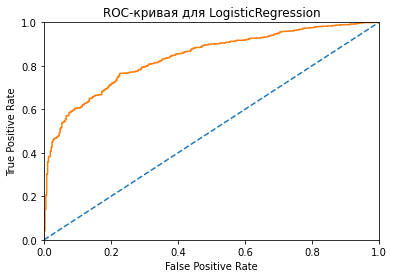

In [55]:
model_lr = LogisticRegression(random_state=random_st, solver='liblinear')
model_lr.fit(features_train, target_train)
predicted_valid = model_lr.predict(features_valid)

# Расчет полноты и точности
accuracy = accuracy_score(target_valid, predicted_valid)
precision = precision_score(target_valid, predicted_valid)
recall = recall_score(target_valid, predicted_valid)

print("Полнота=", recall)
print("Точность (accuracy)=", accuracy)
print("Точность (precision)=", precision)

# F1 метрика
print("F1 =",f1_score(target_valid, predicted_valid))

probabilities_valid = model_lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC-ROC = ", auc_roc)
# Строим ROC- кривую
plt.figure()
# Строим ROC-кривую случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для LogisticRegression')
plt.show()

### DecisionTreeClassifier

In [56]:
for depth in range(1, 100, 9):
     
    model_dtc = DecisionTreeClassifier(random_state=random_st, max_depth=depth)   
    model_dtc.fit(features_train, target_train)
    print("max_depth =", depth, ": ", end='')
    
    
    predictions_valid_dtc = model_dtc.predict(features_valid)
  
    print("recall =",recall_score(target_valid, predictions_valid_dtc), ": ", end='')
    print("precision =",precision_score(target_valid, predictions_valid_dtc), ": ", end='')
    print("accuracy =", accuracy_score(target_valid, predictions_valid_dtc), ": ", end='')
    print("F1 =",f1_score(target_valid, predictions_valid_dtc), ": ", end='')
    probabilities_valid = model_dtc.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print("AUC-ROC = ", auc_roc)

max_depth = 1 : recall = 0.8488372093023255 : precision = 0.8141263940520446 : accuracy = 0.7473385379701917 : F1 = 0.8311195445920303 : AUC-ROC =  0.6591666152612423
max_depth = 10 : recall = 0.8866279069767442 : precision = 0.8472222222222222 : accuracy = 0.7998580553584103 : F1 = 0.8664772727272726 : AUC-ROC =  0.801806386609915
max_depth = 19 : recall = 0.8517441860465116 : precision = 0.846820809248555 : accuracy = 0.7785663591199432 : F1 = 0.8492753623188406 : AUC-ROC =  0.7142719449756337
max_depth = 28 : recall = 0.8498062015503876 : precision = 0.8448940269749519 : accuracy = 0.7757274662881476 : F1 = 0.8473429951690822 : AUC-ROC =  0.711254446569202
max_depth = 37 : recall = 0.8498062015503876 : precision = 0.8448940269749519 : accuracy = 0.7757274662881476 : F1 = 0.8473429951690822 : AUC-ROC =  0.711254446569202
max_depth = 46 : recall = 0.8498062015503876 : precision = 0.8448940269749519 : accuracy = 0.7757274662881476 : F1 = 0.8473429951690822 : AUC-ROC =  0.71125444656920

### RandomForestClassifier

In [57]:
estim_score  = pd.DataFrame(columns=['estimators', 'max_depth', 'recall','precision', 'accuracy', 'F1', 'AUC_ROC'])
for estim in range(1, 100,2):
    for depth_rfc in range(1,20,2):
        model_rfc = RandomForestClassifier(random_state=random_st, n_estimators= estim, max_depth = depth_rfc)
       
        model_rfc.fit(features_train, target_train)
        
        predictions_valid_rfc = model_rfc.predict(features_valid) 
        
        predictions_valid_rfc = model_rfc.predict(features_valid) 
        recall = recall_score(target_valid, predictions_valid_rfc)
        precision = precision_score(target_valid, predictions_valid_rfc)
        accuracy = accuracy_score(target_valid, predictions_valid_rfc)
        f1_rfc = f1_score(target_valid, predictions_valid_rfc)
        
        probabilities_valid = model_rfc.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc_rfc = roc_auc_score(target_valid, probabilities_one_valid)
        estim_score= estim_score.append({'estimators': estim, 'max_depth': depth_rfc, 'recall': recall,
                                         'precision': precision, 'accuracy': accuracy, 'F1': f1_rfc ,
                                         'AUC_ROC':auc_roc_rfc}, ignore_index=True)


print("Лучшие результаты обученных моделей")
display(estim_score.sort_values(by = 'AUC_ROC', ascending = False).head())

Лучшие результаты обученных моделей


,estimators,max_depth,recall,precision,accuracy,F1,AUC_ROC
483,97.0,7.0,0.915698,0.829675,0.800568,0.870567,0.849905
493,99.0,7.0,0.916667,0.830553,0.801987,0.871488,0.849589
443,89.0,7.0,0.916667,0.829097,0.800568,0.870686,0.849525
453,91.0,7.0,0.916667,0.829825,0.801278,0.871087,0.849471
463,93.0,7.0,0.916667,0.829825,0.801278,0.871087,0.849430


Выведем распределение признаков по важности для модели:

In [58]:
feature_imp = pd.DataFrame(model_rfc.feature_importances_, index=features_train.columns, columns=["importance"])
feature_imp = feature_imp.sort_values(by = 'importance',ascending = False).reset_index()
feature_imp.rename(columns={'index':'feature'}, inplace=True)
feature_imp

,feature,importance
0,contract_duration,0.286935
1,monthly_charges,0.210668
2,payment_method_Electronic check,0.049743
3,internet_service_Fiber optic,0.043585
4,type_Two year,0.035943
5,gender_Male,0.032059
6,paperless_billing_Yes,0.028308
7,partner_Yes,0.027410
8,tech_support_True,0.027295
9,type_One year,0.026372


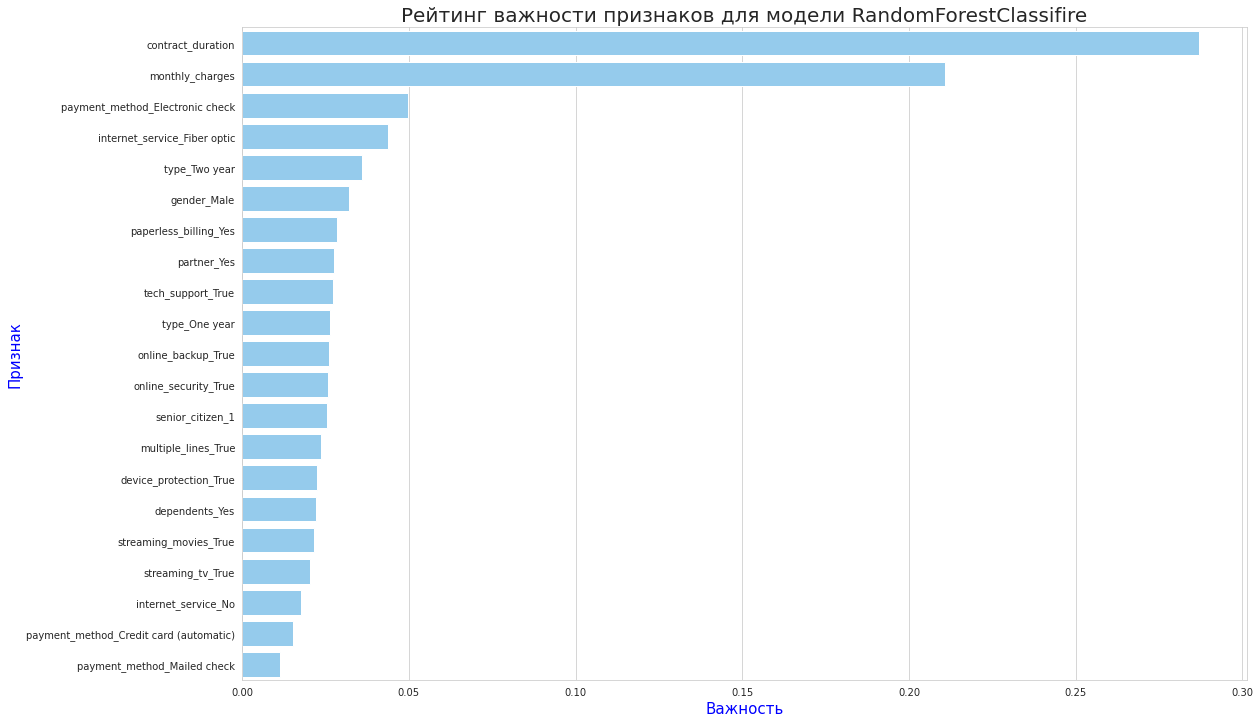

In [59]:
plt.figure(figsize=(18, 12))
with sns.axes_style('whitegrid'):
    sns.barplot(feature_imp['importance'], feature_imp['feature'], color = 'lightskyblue')
    plt.xlabel('Важность', fontsize = 15, color = 'blue')
    plt.ylabel('Признак', fontsize = 15, color = 'blue')
    plt.title('Рейтинг важности признаков для модели RandomForestClassifire', fontsize = 20)
    plt.xticks(rotation= 0)

### LightGBM

In [60]:
%%time

result = pd.DataFrame(columns=['max_depth','n_estimators', 'recall', 'precision', 'accuracy', 'F1', 'AUC_ROC'])
print("Идет обучение модели LightGBM ...")

i=0
for max_depth in range(1,52,5):
    for max_estimators in range(1,202,25):
        model_LGBM = LGBMClassifier(max_depth = max_depth, n_estimators= max_estimators, random_state=random_st)
        model_LGBM.fit(features_train, target_train)
        predictions_valid_LGBM = model_LGBM.predict(features_valid)
        recall = recall_score(target_valid, predictions_valid_LGBM)
        precision = precision_score(target_valid, predictions_valid_LGBM)
        accuracy = accuracy_score(target_valid, predictions_valid_LGBM)
        f1_LGBM = f1_score(target_valid, predictions_valid_LGBM)
        probabilities_valid = model_LGBM.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc_LGBM = roc_auc_score(target_valid, probabilities_one_valid)
        
        result.loc[i] = [max_depth, int(max_estimators), recall, precision, accuracy, f1_LGBM, auc_roc_LGBM]
        #print(result.loc[i])
        i+=1

Идет обучение модели LightGBM ...
CPU times: user 1min 32s, sys: 676 ms, total: 1min 33s
Wall time: 1min 34s


In [61]:
print('Результаты обучения алгоритмом LightGBM', end = '\n')
result.sort_values('AUC_ROC', ascending = False).head()

Результаты обучения алгоритмом LightGBM


,max_depth,n_estimators,recall,precision,accuracy,F1,AUC_ROC
17,6.0,201.0,0.930233,0.875114,0.851668,0.901832,0.904378
16,6.0,176.0,0.930233,0.874317,0.850958,0.901408,0.902815
15,6.0,151.0,0.929264,0.871818,0.848119,0.899625,0.901253
79,41.0,176.0,0.932171,0.875341,0.853087,0.902863,0.899920
97,51.0,176.0,0.932171,0.875341,0.853087,0.902863,0.899920


Выведем рейтинг важности признаков:

In [62]:
feature_imp = pd.DataFrame(model_LGBM.feature_importances_, index=features_train.columns, columns=["importance"])
feature_imp = feature_imp.sort_values(by = 'importance',ascending = False).reset_index()
feature_imp.rename(columns={'index':'feature'}, inplace=True)
feature_imp

,feature,importance
0,contract_duration,2291
1,monthly_charges,1817
2,gender_Male,210
3,payment_method_Electronic check,142
4,online_backup_True,122
5,paperless_billing_Yes,121
6,dependents_Yes,117
7,senior_citizen_1,116
8,partner_Yes,116
9,online_security_True,112


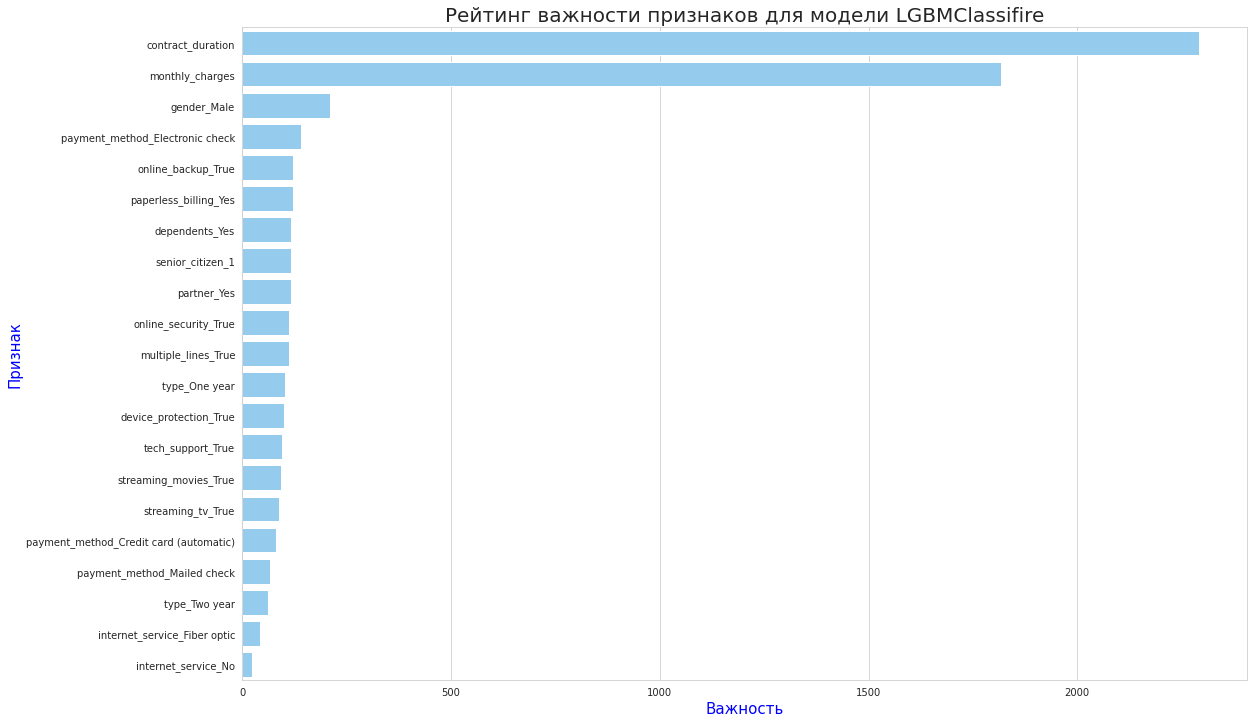

In [63]:
plt.figure(figsize=(18, 12))
with sns.axes_style('whitegrid'):
    sns.barplot(feature_imp['importance'], feature_imp['feature'], color = 'lightskyblue')
    plt.xlabel('Важность', fontsize = 15, color = 'blue')
    plt.ylabel('Признак', fontsize = 15, color = 'blue')
    plt.title('Рейтинг важности признаков для модели LGBMClassifire', fontsize = 20)
    plt.xticks(rotation= 0)

### Catboost & RandomizedSearchCV & GridSearchCV

Заново поделю датасет на тестовую и тренировочную выборки.

In [65]:
features = data.drop(columns=['contract_status', 'total_charges']).reset_index(drop=True)
target = data['contract_status'].reset_index(drop=True)
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=random_st)

Далее использую и тренировочную, и тестовую выборки:  

 #### RandomizedSearchCV
 

In [66]:
def model_search_cv(model, parametrs, features_trn, target_trn):
    model_cv = RandomizedSearchCV( model, 
                                      parametrs,
                                      cv=5,
                                      scoring='roc_auc',
                                      return_train_score=True,
                                      n_jobs=-1,
                                      verbose=1,
                                      random_state=random_st)
        
    model_cv.fit(features_trn, target_trn)         
    return(model_cv.best_score_, model_cv.best_params_, model_cv.best_estimator_)

In [67]:
catboost = CatBoostClassifier(auto_class_weights='Balanced', random_state=random_st, thread_count=1)
params = {'depth':[2, 3, 4, 5, 6],
          'iterations': [100, 250, 500],
          'learning_rate':[0.01, 0.005, 0.001],
          'l2_leaf_reg':[1, 2, 3, 10],
          'logging_level':['Silent'] }

model_search_cv(catboost, params, x_train, y_train)




Fitting 5 folds for each of 10 candidates, totalling 50 fits


(0.863051262270041,
 {'logging_level': 'Silent',
  'learning_rate': 0.005,
  'l2_leaf_reg': 2,
  'iterations': 500,
  'depth': 6},
 <catboost.core.CatBoostClassifier at 0x7f0ba8a2e130>)

Точность (accuracy)= 0.7743080198722498
Точность (precision)= 0.9177592371871275
Полнота= 0.7556427870461236
F1 = 0.8288482238966629
AUC-ROC =  0.8704763342643618


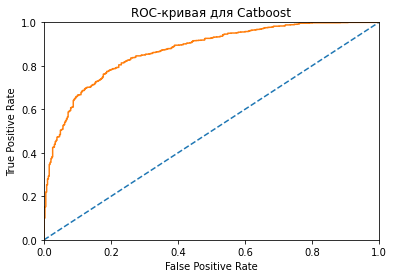

In [68]:
model = CatBoostClassifier(auto_class_weights='Balanced', random_state=random_st, thread_count=1, logging_level='Silent', learning_rate= 0.005, l2_leaf_reg= 2, iterations= 500, depth= 6)

model.fit(x_train, y_train)
test_predictions = model.predict(x_test)


accuracy = accuracy_score(y_test, test_predictions)
precision = precision_score(y_test, test_predictions)
recall = recall_score(y_test, test_predictions)
print('Точность (accuracy)=', accuracy)
print("Точность (precision)=", precision)
print("Полнота=", recall)


print("F1 =",f1_score(y_test, test_predictions))

probabilities_test = model.predict_proba(x_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
auc_roc = roc_auc_score(y_test, probabilities_one_test)
print("AUC-ROC = ", auc_roc)

plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для Catboost')
plt.show()

In [69]:
catboost = CatBoostClassifier(auto_class_weights='Balanced', random_state=random_st, thread_count=1)

grid = GridSearchCV(estimator=catboost,
                    cv=3,
                    param_grid=params,
                    verbose=1,
                    scoring='roc_auc')

grid.fit(x_train, y_train)
best_params = grid.best_params_
print(best_params)

Fitting 3 folds for each of 180 candidates, totalling 540 fits
{'depth': 5, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.01, 'logging_level': 'Silent'}


Точность (accuracy)= 0.7572746628814763
Точность (precision)= 0.9225967540574282
Полнота= 0.7252208047105005
F1 = 0.8120879120879122
AUC-ROC =  0.8567461815253768


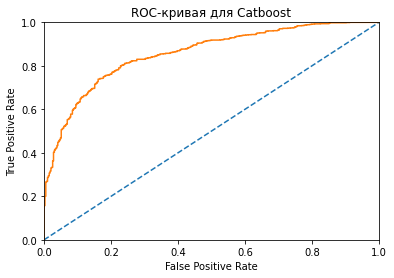

In [70]:
model = CatBoostClassifier(auto_class_weights='Balanced', random_state=random_st, thread_count=1, logging_level='Silent', learning_rate= 0.001, l2_leaf_reg= 1, iterations= 500, depth= 5)

model.fit(x_train, y_train)
test_predictions = model.predict(x_test)


accuracy = accuracy_score(y_test, test_predictions)
precision = precision_score(y_test, test_predictions)
recall = recall_score(y_test, test_predictions)
print('Точность (accuracy)=', accuracy)
print("Точность (precision)=", precision)
print("Полнота=", recall)


print("F1 =",f1_score(y_test, test_predictions))

probabilities_test = model.predict_proba(x_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
auc_roc = roc_auc_score(y_test, probabilities_one_test)
print("AUC-ROC = ", auc_roc)

plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для Catboost')
plt.show()

__ | Результат AUC-ROC | Параметры
:----- | :---- | :----
RandomizedSearchCV | 0.8704763342643618 | 'logging_level': 'Silent',<br>'learning_rate': 0.005,<br>'l2_leaf_reg': 2,<br> 'iterations': 500,<br>'depth': 6
GridSearchCV|0.8567461815253768 |'depth': 5,<br> 'iterations': 500,<br> 'l2_leaf_reg': 1,<br> 'learning_rate': 0.01,<br> 'logging_level': 'Silent'

***Вывод:*** Лучший результат AUC-ROC модели Catboost =	0.8704763342643618 получен при подборе гиперпараметров через RandomizedSearchCV. Тк же, сравнительно с GridSearchCV, скорость работы выше.

Однако, по сравнению с LightGBM, результат AUC-ROC данной модели ниже. Поэтому итоговой моделью так и остается LightGBM.

### Вывод по обучению моделей

Для обучения были использованы алгоритмы: **LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, LightGBM и CatBoost**.
-  испольщуются метрики: AUC_ROC и accuracy.

В результате обучения достигнуты показатели:

Модель| Результаты 
:-----: | :---- 
 LogisticRegression|  полнота (recall):  0.8992248062015504 <br> точность (accuracy): 0.7934705464868701 <br> точность (precision): 0.8322869955156951 <br> F1: 0.864462040055892 <br> **AUC-ROC: 0.83910359221105**
DecisionTreeClassifier| при max-depth = 10 :<br>  recall = 0.8866279069767442 <br>  precision = 0.8472222222222222 <br>  accuracy = 0.7998580553584103 <br>  F1 = 0.8664772727272726 <br> **AUC-ROC =  0.801806386609915**
 RandomForestClassifier| при max-depth = 7 и  estimators = 97:  <br> полнота (recall): 0.915698  <br> точность (accuracy): 0.829675  <br> точность (precision): 0.800568  <br> F1: 0.870567  <br> **AUC-ROC: 0.849905**  <br>
LightGBM| при max_depth = 6 и  estimators = 201: <br> полнота (recall): 0.930233	 <br> точность (accuracy): 0.858765 <br> точность (precision): 0.875114 <br> F1: 0.901832 <br> **AUC-ROC: 0.904378**
Catboost |Точность (accuracy)= 0.7743080198722498<br>Точность (precision)= 0.9177592371871275<br>Полнота= 0.7556427870461236<br>F1 = 0.8288482238966629<br>**AUC-ROC =  0.8704763342643618**



-  для обучения модели  RandomForestClassifier наиболее значимыми признаками являются, как и для LightGBM - *contract_duration, monthly_charges*.
- в качестве модели для тестирования выбрана модель  **LightGBM**, с гиперпараметрами *max_depth= 6* и *estimators= 201*.



## Тестирование модели

Точность (accuracy)= 0.8579545454545454
Точность (precision)= 0.8795289855072463
Полнота= 0.9354527938342967
F1 = 0.9066293183940243
AUC-ROC =  0.906071967921679


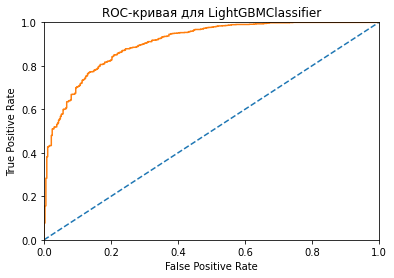

In [71]:
model = LGBMClassifier(max_depth = 6, n_estimators= 201, random_state=random_st)

model.fit(features_train, target_train)
test_predictions = model.predict(features_test)


accuracy = accuracy_score(target_test, test_predictions)
precision = precision_score(target_test, test_predictions)
recall = recall_score(target_test, test_predictions)
print('Точность (accuracy)=', accuracy)
print("Точность (precision)=", precision)
print("Полнота=", recall)


print("F1 =",f1_score(target_test, test_predictions))

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print("AUC-ROC = ", auc_roc)

plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для LightGBMClassifier')
plt.show()

На тестовой выборке получили  **AUC-ROC =  0.906071967921679** с гиперпараметрами *max_depth= 6* и *estimators= 201*.

## Общий вывод

В процессе работы:
- были изучены предоставленные датасеты,  составлен план исследования;
- выполнена предобработка и подготовка  данных, сформирован целевой признак;
- проведен исследовательский анализ данных, построены матрицы корреляции;
- по каждому пункту сделаны выводы;
- далее были сформированы выборки(тренировочная, валидационная и тестовая) и определены модели для обучения:
    - LogisticRegression 
    - DecisionTree, 
    - Random Forest
    - LightGBM
- Были подобраны оптимальные гиперпараметры для моделей.

Лучше всего себя показала модель  **LightGBM**, с гиперпараметрами *max_depth= 6* и *estimators= 201*. Было выполнено обучение на тестовой выборке и получены значения метрик: 




## Итоговый отчёт


***Какие пункты плана были выполнены, а какие — нет (поясните почему)?***<br>
В процессе работы были выполнены все пункты плана, а так же, по мере необходимости, были выполнены действия, не входящие в первоначальный план.
<br><br><br>
***Какие трудности возникли и как вы их преодолели?***<br>
Так как датасет имеет достаточно небольшой объем и дополнительных сведений, расширяющих картину, практически нет, оказалось сложно сделать более "надежные" выводы по результатам вычислений в исследовательской, а так же оптимизировать и расширить эти вычисления или же определить целесообразность тех или иных манипуляций, которые можно было бы включить в исследовательский анализ или которые были включены.
<br><br><br>
***Какие ключевые шаги в решении задачи выделили?***
1. Определение цели и задач исследования.
2. Изучение предоставленных данных, их предобработка и подготовка(в том числе, формирование новых признаков), анализ общего комплекса данных. Так же, оценка факторов, потенциально влияющих на конечный результат. 
3. На основании итогов исследовательского анализа, определить дальнейший порядок действий в отношении алгоритмов машинного обучения. В том числе:
    - решить, все ли признаки будут входить в выборки; 
    - сформировать выборки; 
    - выделить целевой признак; 
    - подготовить данные для передачи в функции; 
    - определиться с тем, какие модели будем использовать и на какие метрики ориентироваться при оценке качества обучения.
4. Обучение моделей с вычислением выбранных метрик и подбором гиперпараметров, повышающих качество обучения. На основании полученных данных выбрать наиболее результативную модели и набор гиперпараметров с лучшим результатом. Так же, параллельно, была произведена оценка значимости признаков для каждой модели. В перспективе это могло помочь улучшению исследования.
5. Тестирование лучшей модели, оценка результатов и формирование общего вывода.
<br><br>
***Какая ваша итоговая модель и какое у неё качество?***<br>
Среди сравниваемых моделей лучше всех показала себя **LightGBM** с гиперпараметрами *max_depth= 6* и *estimators= 201* и **AUC-ROC =  0.906071967921679** на тестовой выборке - соотношение качества и скорости обучения оптимально. *F1 = 0.9066293183940243 и  accuracy= 0.8579545454545454*. Результат на тестовой выборке вышел примерно равным результату на валидационной.
